# Linear Models

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# import libraries
import numpy as np
import matplotlib as mp
import pandas as pd
import matplotlib.pyplot as plt
import laUtilities as ut
import slideUtilities as sl
import pandas as pd
from importlib import reload
from datetime import datetime
from IPython.display import Image
from IPython.display import display_html
from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML

import scipy as sp
import scipy.sparse.linalg as linalg
import scipy.cluster.hierarchy as hr
from scipy.spatial.distance import pdist, squareform

import sklearn.datasets as datasets
import sklearn.metrics as metrics
import sklearn.utils as utils
import sklearn.linear_model as linear_model
#import sklearn.cross_validation as cross_validation
import sklearn.cluster as cluster
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

from patsy import dmatrices

import seaborn as sns

print('')

In [4]:
%%html
<style>
 .container.slides .celltoolbar, .container.slides .hide-in-slideshow {
    display: None ! important;
}
</style>

%Set up useful MathJax (Latex) macros.
%See http://docs.mathjax.org/en/latest/tex.html#defining-tex-macros
%These are for use in the slideshow
$\newcommand{\mat}[1]{\left[\begin{array}#1\end{array}\right]}$
$\newcommand{\vx}{{\mathbf x}}$
$\newcommand{\hx}{\hat{\mathbf x}}$
$\newcommand{\vbt}{{\mathbf\beta}}$
$\newcommand{\vy}{{\mathbf y}}$
$\newcommand{\vz}{{\mathbf z}}$
$\newcommand{\R}{{\mathbb{R}}}$
$\newcommand{\vu}{{\mathbf u}}$
$\newcommand{\vv}{{\mathbf v}}$
$\newcommand{\vw}{{\mathbf w}}$
$\newcommand{\col}{{\operatorname{Col}}}$
$\newcommand{\nul}{{\operatorname{Nul}}}$
$\newcommand{\vb}{{\mathbf b}}$
$\newcommand{\va}{{\mathbf a}}$
$\newcommand{\ve}{{\mathbf e}}$
$\newcommand{\setb}{{\mathcal{B}}}$
$\newcommand{\rank}{{\operatorname{rank}}}$
$\newcommand{\vp}{{\mathbf p}}$

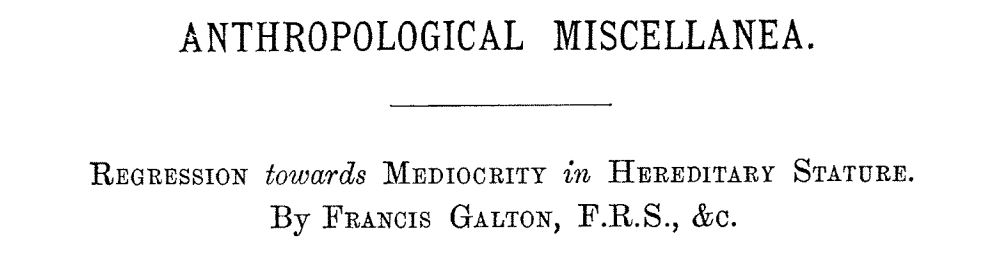

In [5]:
# image credit
sl.hide_code_in_slideshow()
display(Image("figs/galton-title.png", width=550))

In 1886 Francis Galton published his observations about how random factors affect outliers.

This notion has come to be called "regression to the mean" because unusually large or small phenomena, after the influence of random events, become closer to their mean values (less extreme).

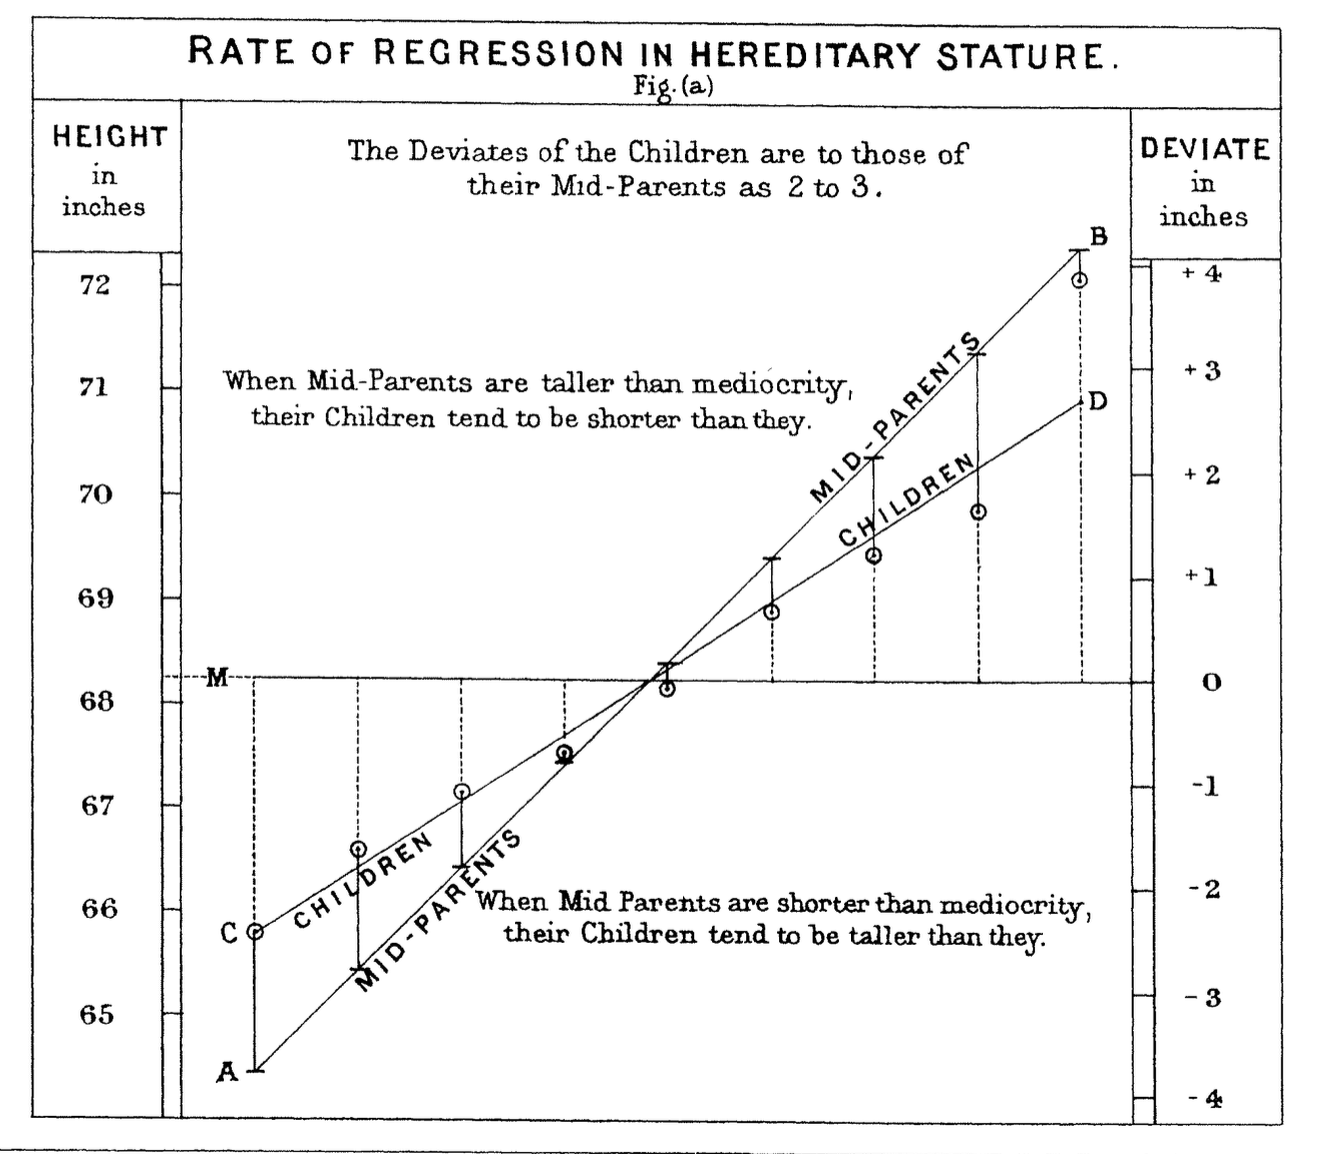

In [6]:
# image credit:
sl.hide_code_in_slideshow()
display(Image("figs/galton-regression.png", width=550))

The most common form of machine learning is __regression__, which means constructing an equation that describes the relationships among variables.

It is a form of supervised learning: whereas __classification__ deals with predicting categorical features (labels or classes), __regression__ deals with predicting continuous features (real values).

For example, we may look at these points and decide to model them using a line.

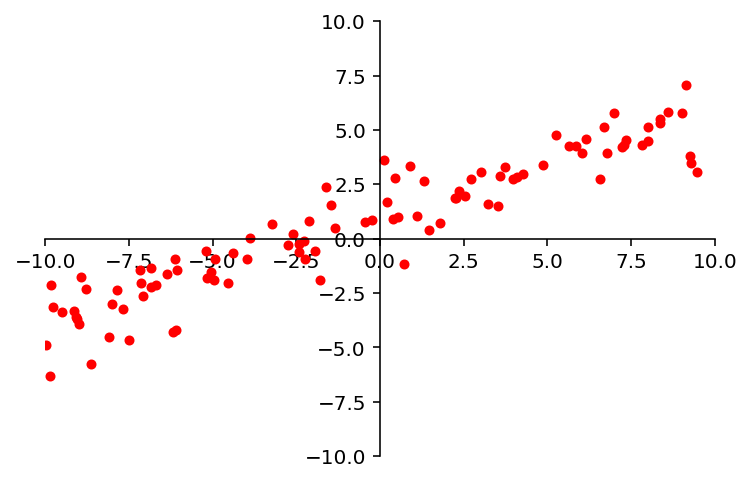

In [7]:
# No need to study this code unless you want to.
sl.hide_code_in_slideshow()
ax = ut.plotSetup(-10,10,-10,10)
ut.centerAxes(ax)
line = np.array([1, 0.5])
xlin = -10.0 + 20.0 * np.random.random(100)
ylin = line[0]+(line[1]*xlin)+np.random.randn(100)
ax.plot(xlin,ylin,'ro',markersize=4)
print('')

We may look at these points and decide to model them using a quadratic function.

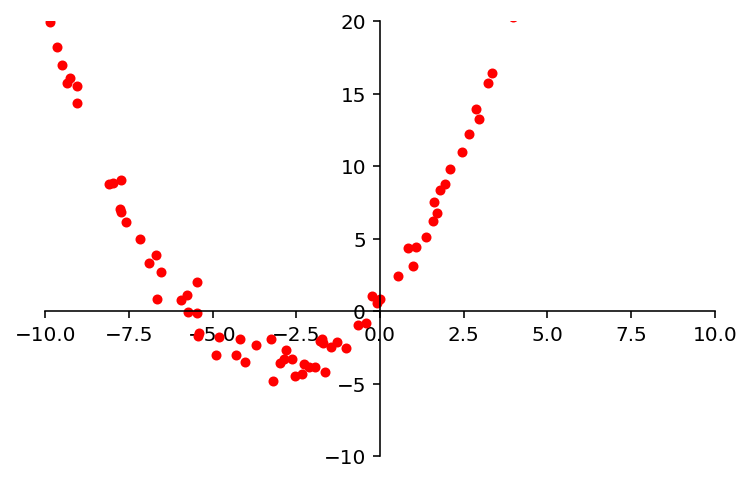

In [8]:
# No need to study this code unless you want to.
sl.hide_code_in_slideshow()
ax = ut.plotSetup(-10,10,-10,20)
ut.centerAxes(ax)
quad = np.array([1, 3, 0.5])
xquad = -10.0 + 20.0 * np.random.random(100)
yquad = quad[0]+(quad[1]*xquad)+(quad[2]*xquad*xquad)+np.random.randn(100)
ax.plot(xquad,yquad,'ro',markersize=4)
print('')

And we may look at these points and decide to model them using a logarithmic function.

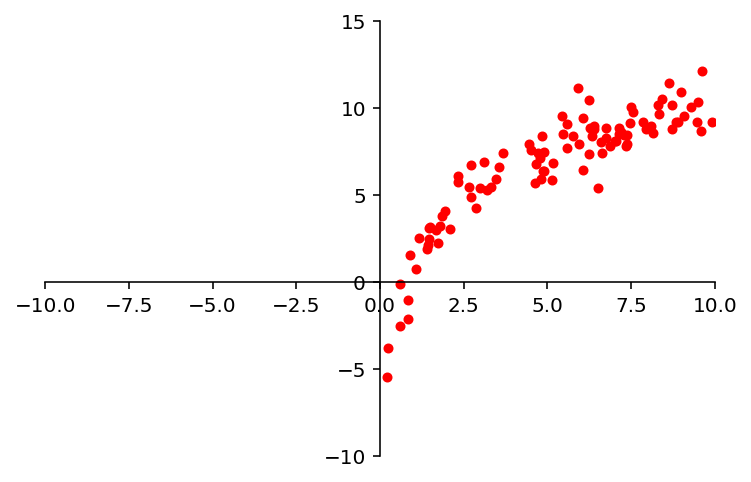

In [9]:
# No need to study this code unless you want to.
sl.hide_code_in_slideshow()
ax = ut.plotSetup(-10,10,-10,15)
ut.centerAxes(ax)
log = np.array([1, 4])
xlog = 10.0 * np.random.random(100)
ylog = log[0]+log[1]*np.log(xlog)+np.random.randn(100)
ax.plot(xlog,ylog,'ro',markersize=4)
print('')

Clearly, none of these datasets agrees perfectly with the proposed model.   So the question arises:

How do we find the __best__ linear function (or quadratic function, or logarithmic function) given the data?

__Framework.__

This problem has been studied extensively in the field of statistics.   Certain terminology is used:

* Some values are referred to as "independent," and
* Some values are referred to as "dependent."

The basic regression task is: given a set of independent variables and the associated dependent variables, estimate the parameters of a model (such as a line, parabola, etc) that describes how the dependent variables are related to the independent variables.

The independent variables are collected into a matrix $X,$ which is called the __design matrix.__

The dependent variables are collected into an __observation__ vector $\vy.$

The parameters of the model (for any kind of model) are collected into a __parameter__ vector $\beta.$

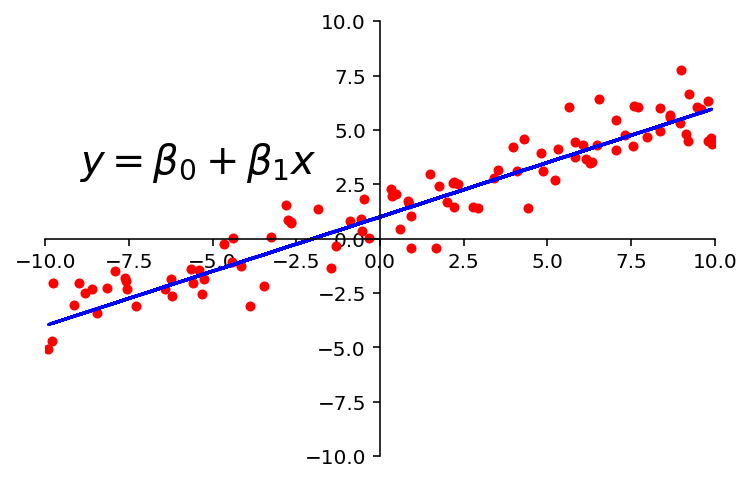

In [10]:
# No need to study this code unless you want to.
sl.hide_code_in_slideshow()
ax = ut.plotSetup(-10,10,-10,10)
ut.centerAxes(ax)
line = np.array([1, 0.5])
xlin = -10.0 + 20.0 * np.random.random(100)
ylin = line[0]+(line[1]*xlin)+np.random.randn(100)
ax.plot(xlin,ylin,'ro',markersize=4)
ax.plot(xlin,line[0]+line[1]*xlin,'b-')
plt.text(-9,3,r'$y = \beta_0 + \beta_1x$',size=20)
print('')

## Least-Squares Lines

The first kind of model we'll study is a linear equation, $y = \beta_0 + \beta_1 x.$

Experimental data often produce points $(x_1, y_1), \dots, (x_n,y_n)$ that seem to lie close to a line.   

We want to determine the parameters $\beta_0, \beta_1$ that define a line that is as "close" to the points as possible.

Suppose we have a line $y = \beta_0 + \beta_1 x$.   For each data point $(x_j, y_j),$ there is a point $(x_j, \beta_0 + \beta_1 x_j)$ that is the point on the line with the same $x$-coordinate.

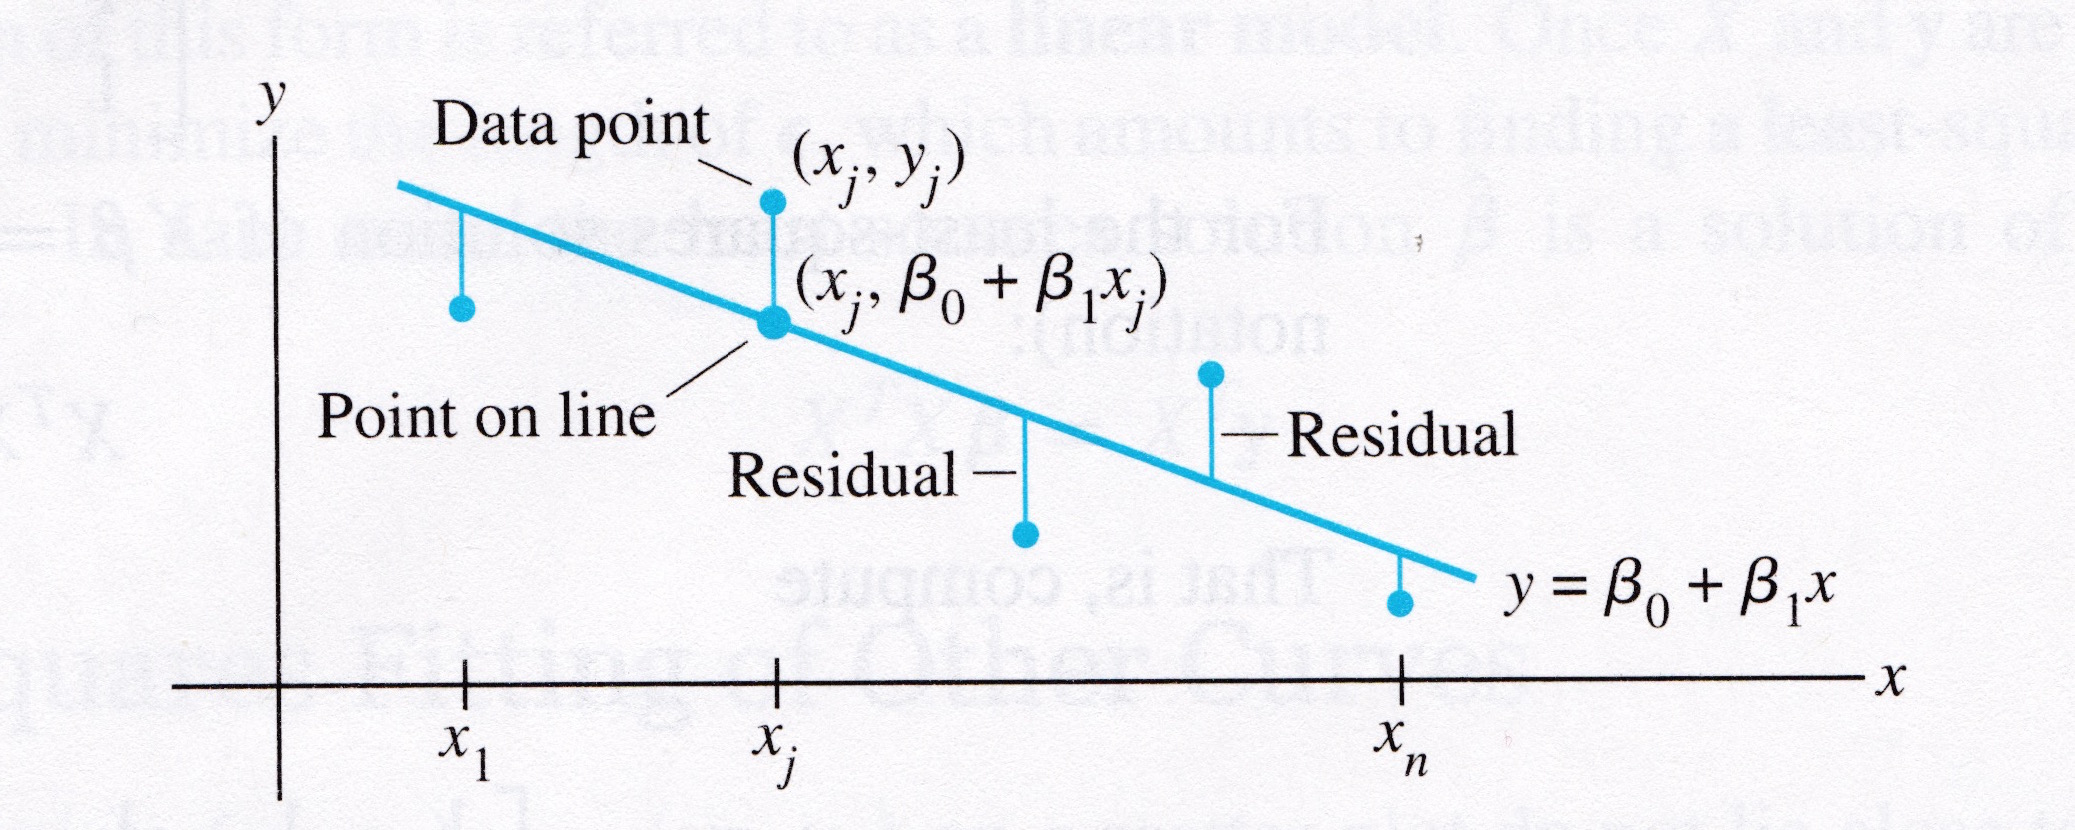

In [11]:
# image credit: Lay, LAA, 4th edition
sl.hide_code_in_slideshow()
display(Image("figs/Lay-fig-6-6-1.jpg", width=550))

We call $y_j$ the __observed__ value of $y$ and $\beta_0 + \beta_1 x_j$ the __predicted__ $y$-value.   

The difference between an observed $y$-value and a predicted $y$-value is called a __residual__.

There are several ways of measure how "close" the line is to the data. 

The usual choice is to sum the squares of the residuals.  

The __least-squares line__ is the line $y = \beta_0 + \beta_1x$ that minimizes the sum of squares of the residuals. 

The coefficients $\beta_0, \beta_1$ of the line are called __regression coefficients.__

__A least-squares problem.__

If the data points were on the line, the parameters $\beta_0$ and $\beta_1$ would satisfy the equations

$$\beta_0 + \beta_1 x_1 = y_1 $$
$$\beta_0 + \beta_1 x_2 = y_2 $$
$$\beta_0 + \beta_1 x_3 = y_3 $$
$$ \vdots$$
$$\beta_0 + \beta_1 x_n = y_n $$

We can write this system as 

$$X\vbt = \vy,\;\;\;\;\mbox{where}\;X=\mat{{cc}1&x_1\\1&x_2\\\vdots&\vdots\\1&x_n},\;\;\vbt = \mat{{c}\beta_0\\\beta_1},\;\;\vy=\mat{{c}y_1\\y_2\\\vdots\\y_n}$$

Of course, if the data points don't actually lie exactly on a line, 

... then there are no parameters $\beta_0, \beta_1$ for which the predicted $y$-values in $X\vbt$ equal the observed $y$-values in $\vy$, 

... and $X\vbt=\vy$ has no solution.

Note that we are seeking the $\beta$ that minimizes the sum of squared residuals, ie,

$$\sum_i (\beta_0 + \beta_1 x_i - y_i)^2=\Vert X\beta -\vy\Vert^2$$

This is key: __the sum of squares of the residuals__ is __exactly__ the __square of the distance between the vectors $X\vbt$ and $\vy.$__

This is a least-squares problem, $A\vx = \vb,$ with different notation.

Computing the least-squares solution of $X\beta = \vy$ is equivalent to finding the $\vbt$ that determines the least-squares line.

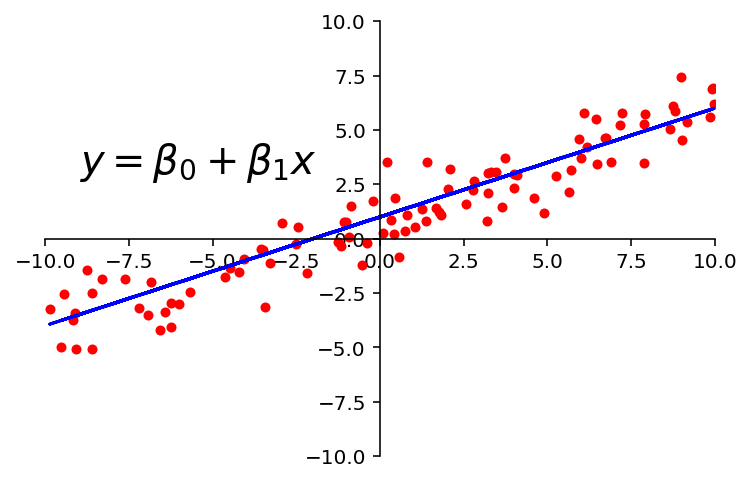

In [12]:
# No need to study this code unless you want to.
sl.hide_code_in_slideshow()
ax = ut.plotSetup(-10,10,-10,10)
ut.centerAxes(ax)
line = np.array([1, 0.5])
xlin = -10.0 + 20.0 * np.random.random(100)
ylin = line[0]+(line[1]*xlin)+np.random.randn(100)
ax.plot(xlin,ylin,'ro',markersize=4)
ax.plot(xlin,line[0]+line[1]*xlin,'b-')
plt.text(-9,3,r'$y = \beta_0 + \beta_1x$',size=20)
print('')

Now, to obtain the least-squares line, find the least-squares solution to $X\vbt = \vy.$

From linear algebra we know that the least squares solution of $X\vbt = \vy$ is given by the solution of the __normal equations__:

$$X^TX\vbt = X^T\vy$$

We also know that the normal equations __always__ have at least one solution.

And if $X^TX$ is invertible, there is a unique solution that is given by:
    
$$\vbt = (X^TX)^{-1} X^T\vy$$

## The General Linear Model

Another way that the inconsistent linear system is often written is to collect all the residuals into a __residual vector.__ 

Then an exact equation is

$$\mathbf{y} = X\vbt + {\mathbf\epsilon}$$

$\beta_0+\beta_1 x_1 = y_1+\epsilon_1$

$\beta_0+\beta_1 x_2 = y_2+\epsilon_2$

$\vdots$ 

$\beta_0+\beta_1 x_n = y_n+\epsilon_n$


Any equation of this form is referred to as a __linear model.__ 

In this formulation, the goal is to find the $\beta$ so as to minimize the length of $\epsilon$, ie, $\Vert\epsilon\Vert.$

In some cases, one would like to fit data points with something other than a straight line.  

In cases like this, the matrix equation is still $X\vbt = \vy$, but the specific form of $X$ changes from one problem to the next.

## Least-Squares Fitting of Other Models

Most models have parameters, and the objection of __model fitting__ is to to fix those parameters.   Let's talk about model parameters.

In model fitting, the parameters are the unknown.  A central question for us is whether the model is _linear_ in its parameters.

For example, the model $y = \beta_0 e^{-\beta_1 x}$ is __not__ linear in its parameters.  The model $y = \beta_0 e^{-2 x}$ __is__ linear in its parameters.

For a model that is linear in its parameters, an observation is a linear combination of (arbitrary) known functions.

In other words, a model that is linear in its parameters is

$$y = \beta_0f_0(x) + \beta_1f_1(x) + \dots + \beta_nf_n(x)$$

where $f_0, \dots, f_n$ are known functions and $\beta_0,\dots,\beta_k$ are parameters.

__Example.__  Suppose data points $(x_1, y_1), \dots, (x_n, y_n)$ appear to lie along some sort of parabola instead of a straight line.  Suppose we wish to approximate the data by an equation of the form

$$y = \beta_0 + \beta_1x + \beta_2x^2.$$

Describe the linear model that produces a "least squares fit" of the data by the equation.

__Solution.__  The ideal relationship is $y = \beta_0 + \beta_1x + \beta_2x^2.$

Suppose the actual values of the parameters are $\beta_0, \beta_1, \beta_2.$  Then the coordinates of the first data point satisfy the equation

$$y_1 = \beta_0 + \beta_1x_1 + \beta_2x_1^2 + \epsilon_1$$

where $\epsilon_1$ is the residual error between the observed value $y_1$ and the predicted $y$-value.

Each data point determines a similar equation:

$$y_1 = \beta_0 + \beta_1x_1 + \beta_2x_1^2 + \epsilon_1$$
$$y_2 = \beta_0 + \beta_1x_2 + \beta_2x_2^2 + \epsilon_2$$
$$\vdots$$
$$y_n = \beta_0 + \beta_1x_n + \beta_2x_n^2 + \epsilon_n$$

Clearly, this system can be written as $\vy = X\vbt + \mathbf{\epsilon}.$

$$\mat{{c}y_1\\y_2\\\vdots\\y_n} = \mat{{ccc}1&x_1&x_1^2\\1&x_2&x_2^2\\\vdots&\vdots&\vdots\\1&x_n&x_n^2} \mat{{ccc}\beta_0\\\beta_1\\\beta_2} + \mat{{c}\epsilon_1\\\epsilon_2\\\vdots\\\epsilon_n}$$

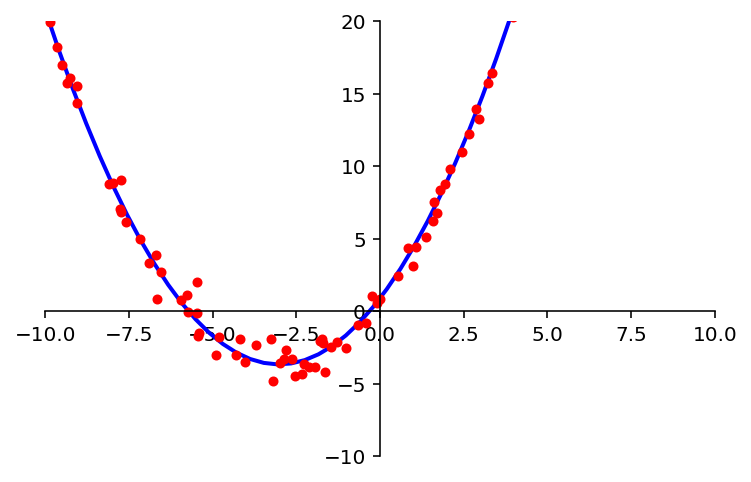

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import laUtilities as ut
#
# Input data are in the vectors xquad and yquad
#
# estimate the parameters of the linear model
#
m = np.shape(xquad)[0]
X = np.array([np.ones(m),xquad,xquad**2]).T
beta = np.linalg.inv(X.T @ X) @ X.T @ yquad
#
# plot the results
#
ax = ut.plotSetup(-10,10,-10,20)
ut.centerAxes(ax)
xplot = np.linspace(-10,10,50)
yestplot = beta[0]+beta[1]*xplot+beta[2]*xplot**2
ax.plot(xplot,yestplot,'b-',lw=2)
ax.plot(xquad,yquad,'ro',markersize=4)
print('')

Let's consider the logarithmic relationship. In the ideal model we will have:

$y = \beta_0+\beta_1 \log(x)$

This is a linear model!

But the points do not satisfy this relationship exactly.  They look like this:

$y_1 = \beta_0+\beta_1\log(x_1)+\epsilon_1$

$y_2 = \beta_0+\beta_1 \log(x_2)+\epsilon_2$

$\vdots$

$y_n = \beta_0+\beta_1 \log(x_n)+\epsilon_n$


$\mathbf{y}= X\mathbf{\beta}+\mathbf{\epsilon}$


$$\mat{{c}y_1\\y_2\\\vdots\\y_n} = \mat{{cc}1&\log(x_1)\\1&\log(x_2)\\\vdots&\vdots\\1&\log(x_n)} \mat{{cc}\beta_0\\\beta_1} + \mat{{c}\epsilon_1\\\epsilon_2\\\vdots\\\epsilon_n}$$

$\mathbf{\beta} = (X^TX)^{-1}X^T\mathbf{y}$

/Users/evimaria/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log


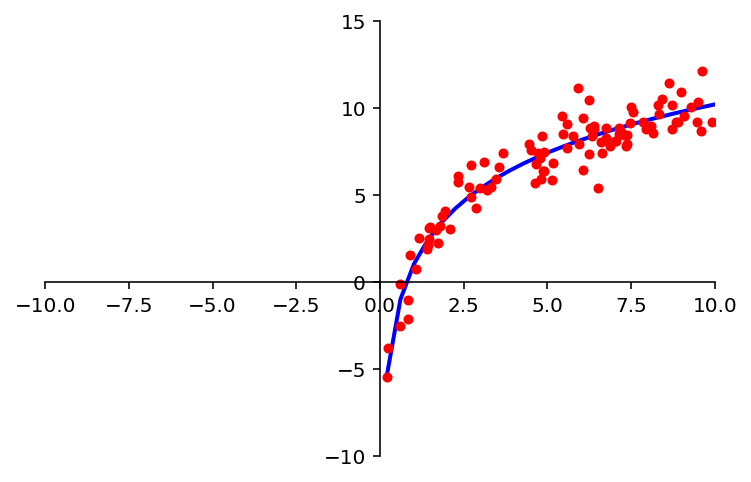

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import laUtilities as ut
#
# Input data are in the vectors xlog and ylog
#
# estimate the parameters of the linear model
#
m = np.shape(xlog)[0]
X = np.array([np.ones(m),np.log(xlog)]).T
beta = np.linalg.inv(X.T @ X) @ X.T @ ylog
# 
# plot the results
#
ax = ut.plotSetup(-10,10,-10,15)
ut.centerAxes(ax)
xplot = np.linspace(-10,10,50)
yestplot = beta[0]+beta[1]*np.log(xplot)
ax.plot(xplot,yestplot,'b-',lw=2)
ax.plot(xlog,ylog,'ro',markersize=4)
print('')

## Multiple Regression

Suppose an experiment involves two independent variables -- say, $u$ and $v$, -- and one dependent variable, $y$.  A simple equation for predicting $y$ from $u$ and $v$ has the form

$$y = \beta_0 + \beta_1 u + \beta_2 v$$

Since there is more than one independent variable, this is called __multiple regression.__

A more general prediction equation might have the form

$$y = \beta_0 + \beta_1 u + \beta_2 v + \beta_3u^2 + \beta_4 uv + \beta_5 v^2$$

A least squares fit to equations like this is called a __trend surface.__

In general, a linear model will arise whenever $y$ is to be predicted by an equation of the form

$$y = \beta_0f_0(u,v) + \beta_1f_1(u,v) + \cdots + \beta_kf_k(u,v)$$

with $f_0,\dots,f_k$ any sort of known functions and $\beta_0,...,\beta_k$ unknown weights.

Let's take an example.   Here are a set of points in $\R^3$:

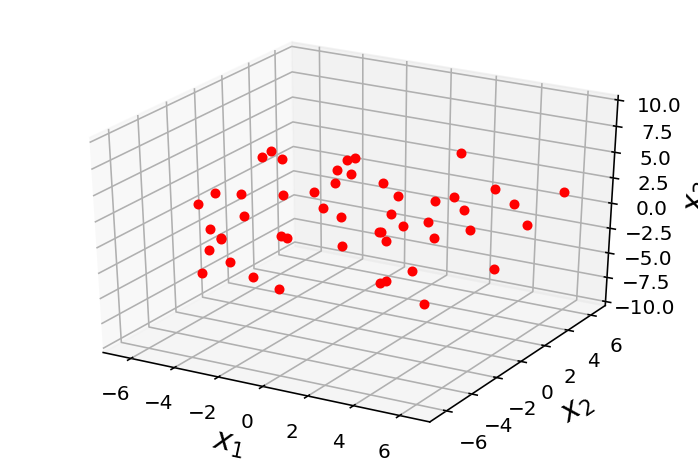

In [15]:
# %matplotlib qt
%matplotlib inline
sl.hide_code_in_slideshow()
ax = ut.plotSetup3d(-7,7,-7,7,-10,10)
v = [4.0,4.0,2.0]
u = [-4.0,3.0,1.0]
# plotting the span of v
# ut.plotSpan3d(ax,u,v,'Green')
npts = 50
# set locations of points that fall within x,y
xc = -7.0 + 14.0 * np.random.random(npts)
yc = -7.0 + 14.0 * np.random.random(npts)
A = np.array([u,v]).T
# project these points onto the plane
P = A.dot(np.linalg.inv(A.T.dot(A))).dot(A.T)
coords = P.dot(np.array([xc,yc,np.zeros(npts)]))
coords[2] += np.random.randn(npts)
ax.plot(coords[0],coords[1],'ro',zs=coords[2],markersize=4)
print('')

__Example.__  In geography, local models of terrain are constructed from data $(u_1, v_1, y_1), \dots, (u_n, v_n, y_n)$ where $u_j, v_j$, and $y_j$ are latitude, longitude, and altitude, respectively.

Let's describe the linear models that gives a least-squares fit to such data.  The solution is called the least-squares _plane._

__Solution.__  We expect the data to satisfy these equations:

$$y_1 = \beta_0 + \beta_1 u_1 + \beta_2 v_1 + \epsilon_1$$
$$y_2 = \beta_0 + \beta_1 u_2 + \beta_2 v_2 + \epsilon_2$$
$$\vdots$$
$$y_n = \beta_0 + \beta_1 u_n + \beta_2 v_n + \epsilon_n$$

This system has the matrix for $\vy = X\vbt + \epsilon,$ where

$$\vy = \mat{{c}y_1\\y_1\\\vdots\\y_n},\;\;X = \mat{{ccc}1&u_1&v_1\\1&u_2&v_2\\\vdots&\vdots&\vdots\\1&u_n&v_n},\;\;\vbt=\mat{{c}\beta_0\\\beta_1\\\beta_2},\;\;\epsilon = \mat{{c}\epsilon_1\\\epsilon_2\\\vdots\\\epsilon_n}$$

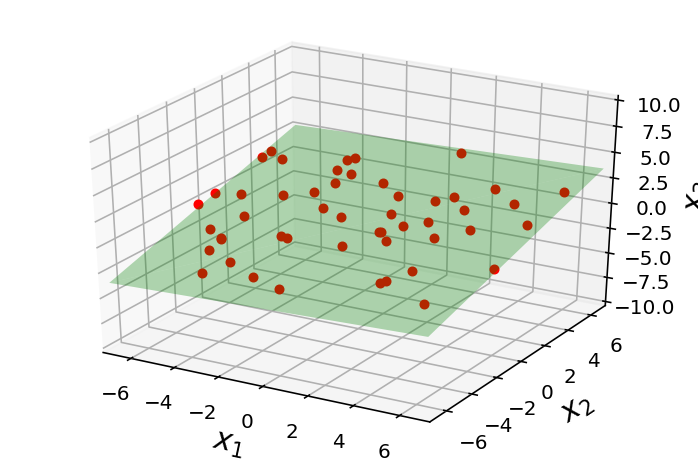

In [16]:
%matplotlib inline
sl.hide_code_in_slideshow()
ax = ut.plotSetup3d(-7,7,-7,7,-10,10)
v = [4.0,4.0,2.0]
u = [-4.0,3.0,1.0]
# plotting the span of v
ut.plotSpan3d(ax,u,v,'Green')
npts = 50
# set locations of points that fall within x,y
# xc = -7.0 + 14.0 * np.random.random(npts)
# yc = -7.0 + 14.0 * np.random.random(npts)
# A = np.array([u,v]).T
# project these points onto the plane
# P = A.dot(np.linalg.inv(A.T.dot(A))).dot(A.T)
# coords = P.dot(np.array([xc,yc,np.zeros(npts)]))
# coords[2] += np.random.randn(npts)
ax.plot(coords[0],coords[1],'ro',zs=coords[2],markersize=4)
# plt.show()
print('')

This example shows that the linear model for multiple regression has the same abstract form as the model for the simple regression in the earlier examples.

We can see that there the general principle is the same across all the different kinds of linear models.

Once $X$ is defined properly, the normal equations for $\vbt$ have the same matrix form, no matter how many variables are involved.

Thus, for any linear model where $X^TX$ is invertible, the least squares $\hat{\vbt}$ is given by $(X^TX)^{-1}X^T\vy$.

## Measuring the fit of a regression model and $R^2$

Given any $X$ and $\vy$, the above algorithm will produce an output $\hat{\beta}$.

But how do we know whether the data is in fact well described by the model?

The most common measure of fit is $R^2$.

$R^2$ measures the fraction of the variance of $\vy$ that can be explained by the model $X\hat{\beta}$.

The variance of $\vy$ is $\text{Var}(\vy) =\frac{1}{n} \sum_{i=1}^n \left(y_i-\overline{y}\right)^2$
where:
$\overline{y}=\frac{1}{n}\sum_{i=1}^ny_i$

For any given $n$, we can equally work with just 
$$\sum_{i=1}^n \left(y_i-\overline{y}\right)^2$$
which is called the __Total Sum of Squares__ (TSS).

Now to measure the quality of a model, we break TSS down into two components. 

For any given $\vx_i$, the prediction made by the model is $\hat{y_i} = \vx_i^T\beta$.

Therefore, the residual $\epsilon$ is $y_i - \hat{y_i}$, and the part that the model "explains" is $\hat{y_i} - \overline{y}.$

Then it turns out that the total sum of squares is exactly equal to the sum of squares of the residuals plus the sum of squares of the explained part.

In other words:

$$\text{TSS} = \text{SSR} + \text{ESS},$$

where Residual Sum of Squares (RSS) is:

$$\text{RSS} = \sum_{i=1}^n \left(y_i-\hat{y_i}\right)^2,$$

and Explained Sum of Squares (ESS) is:

$$\text{ESS} = \sum_{i=1}^n \left(\hat{y_i}-\overline{y}\right)^2,$$

Now, a good fit is one in which the model explains a large part of the variance of $\vy$.  

So the measure of fit $R^2$ is defined as:

\begin{eqnarray}
R^2 & = & \frac{\text{ESS}}{\text{TSS}} = 1-\frac{\text{RSS}}{\text{TSS}}
\end{eqnarray}


$0\leq R^2\leq 1$; the closer the value of $R^2$ is to $1$ the better the fit of the regression; small values of RSS imply that the residuals are small and therefore we have a better fit.

## OLS in Practice

In [17]:
X, y = datasets.make_regression(n_samples=100, n_features=20, n_informative=5, bias=0.1, noise=30, random_state=1)
print(X.shape, y.shape)

(100, 20) (100,)


In [18]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.969
Model:                            OLS   Adj. R-squared (uncentered):              0.961
Method:                 Least Squares   F-statistic:                              123.8
Date:                Tue, 17 Mar 2020   Prob (F-statistic):                    1.03e-51
Time:                        13:23:55   Log-Likelihood:                         -468.30
No. Observations:                 100   AIC:                                      976.6
Df Residuals:                      80   BIC:                                      1029.
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

The $R^2$ value is very good.   We can see that the linear model does a very good job of predicting the observations $y_i$.

However, some of the independent variables may not contribute to the accuracy of the prediction. 

Note that each parameters of an independent variable has an associated confidence interval. 

If a coefficient is not distinguishable from zero, then we cannot assume that there is any relationship between the independent variable and the observations.

In other words, if the confidence interval for the parameter includes zero, the associated independent variable may not have any predictive value.

In [19]:
print('Confidence Intervals: {}'.format(results.conf_int()))
print('Parameters: {}'.format(results.params))

Confidence Intervals: [[  5.65891465  19.47559281]
 [ -9.44032559   1.77614877]
 [ -9.31636359   4.47701749]
 [ -4.12661379   8.15524508]
 [ -9.4808662    4.22965424]
 [ -5.49698033   7.07574692]
 [-10.22359973   4.08684835]
 [ 83.74738375  96.52928603]
 [ -6.77896356   6.75226985]
 [  8.80365396  21.73126149]
 [ -6.86882065   6.4194618 ]
 [ -6.97868351   7.1332267 ]
 [ -6.71228582   6.2218515 ]
 [ 82.96557061  97.07028228]
 [ -5.74782503   9.08465366]
 [ -1.06173893   9.85081724]
 [  2.02753258  15.5561241 ]
 [ 66.56165458  80.19256546]
 [ -8.90825108   5.0804296 ]
 [ -7.85545335   5.21424811]]
Parameters: [ 1.25672537e+01 -3.83208841e+00 -2.41967305e+00  2.01431564e+00
 -2.62560598e+00  7.89383294e-01 -3.06837569e+00  9.01383349e+01
 -1.33468527e-02  1.52674577e+01 -2.24679428e-01  7.72715974e-02
 -2.45217158e-01  9.00179264e+01  1.66841432e+00  4.39453916e+00
  8.79182834e+00  7.33771100e+01 -1.91391074e+00 -1.32060262e+00]


In [20]:
CIs = results.conf_int()
notSignificant = (CIs[:,0] < 0) & (CIs[:,1] > 0)
notSignificant

array([False,  True,  True,  True,  True,  True,  True, False,  True,
       False,  True,  True,  True, False,  True,  True, False, False,
        True,  True])

In [21]:
Xsignif = X[:,~notSignificant]
Xsignif.shape

(100, 6)

By eliminating independent variables that are not significant, we help avoid overfitting.

In [22]:
model = sm.OLS(y, Xsignif)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.965
Model:                            OLS   Adj. R-squared (uncentered):              0.963
Method:                 Least Squares   F-statistic:                              437.1
Date:                Mon, 16 Mar 2020   Prob (F-statistic):                    2.38e-66
Time:                        15:21:08   Log-Likelihood:                         -473.32
No. Observations:                 100   AIC:                                      958.6
Df Residuals:                      94   BIC:                                      974.3
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Real Data: California Housing

In [23]:
ca = pd.read_table("data/cal_housing.data", sep=',')

attributes = ['longitude',
            'latitude',
            'housingMedianAge',
            'totalRooms',
            'totalBedrooms',
            'population',
            'households',
            'medianIncome',
            'medianHouseValue']

ca.columns = attributes

ca.info()
ca.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20639 entries, 0 to 20638
Data columns (total 9 columns):
longitude           20639 non-null float64
latitude            20639 non-null float64
housingMedianAge    20639 non-null float64
totalRooms          20639 non-null float64
totalBedrooms       20639 non-null float64
population          20639 non-null float64
households          20639 non-null float64
medianIncome        20639 non-null float64
medianHouseValue    20639 non-null float64
dtypes: float64(9)
memory usage: 1.4 MB


,longitude,latitude,housingMedianAge,totalRooms,totalBedrooms,population,households,medianIncome,medianHouseValue
0,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
1,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
2,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
3,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0
4,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0
5,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0
6,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0
7,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0
8,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0
9,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0


In [24]:
X_CA_H = ca[['longitude','latitude','housingMedianAge','totalRooms',
             'totalBedrooms','population','households','medianIncome']]
print('Complete dataset shape is {}'.format(X_CA_H.shape))
print('Sample median house values:')
print(ca.medianHouseValue.head())
y_CA_H = ca.medianHouseValue;


Complete dataset shape is (20639, 8)
Sample median house values:
0    358500.0
1    352100.0
2    341300.0
3    342200.0
4    269700.0
Name: medianHouseValue, dtype: float64


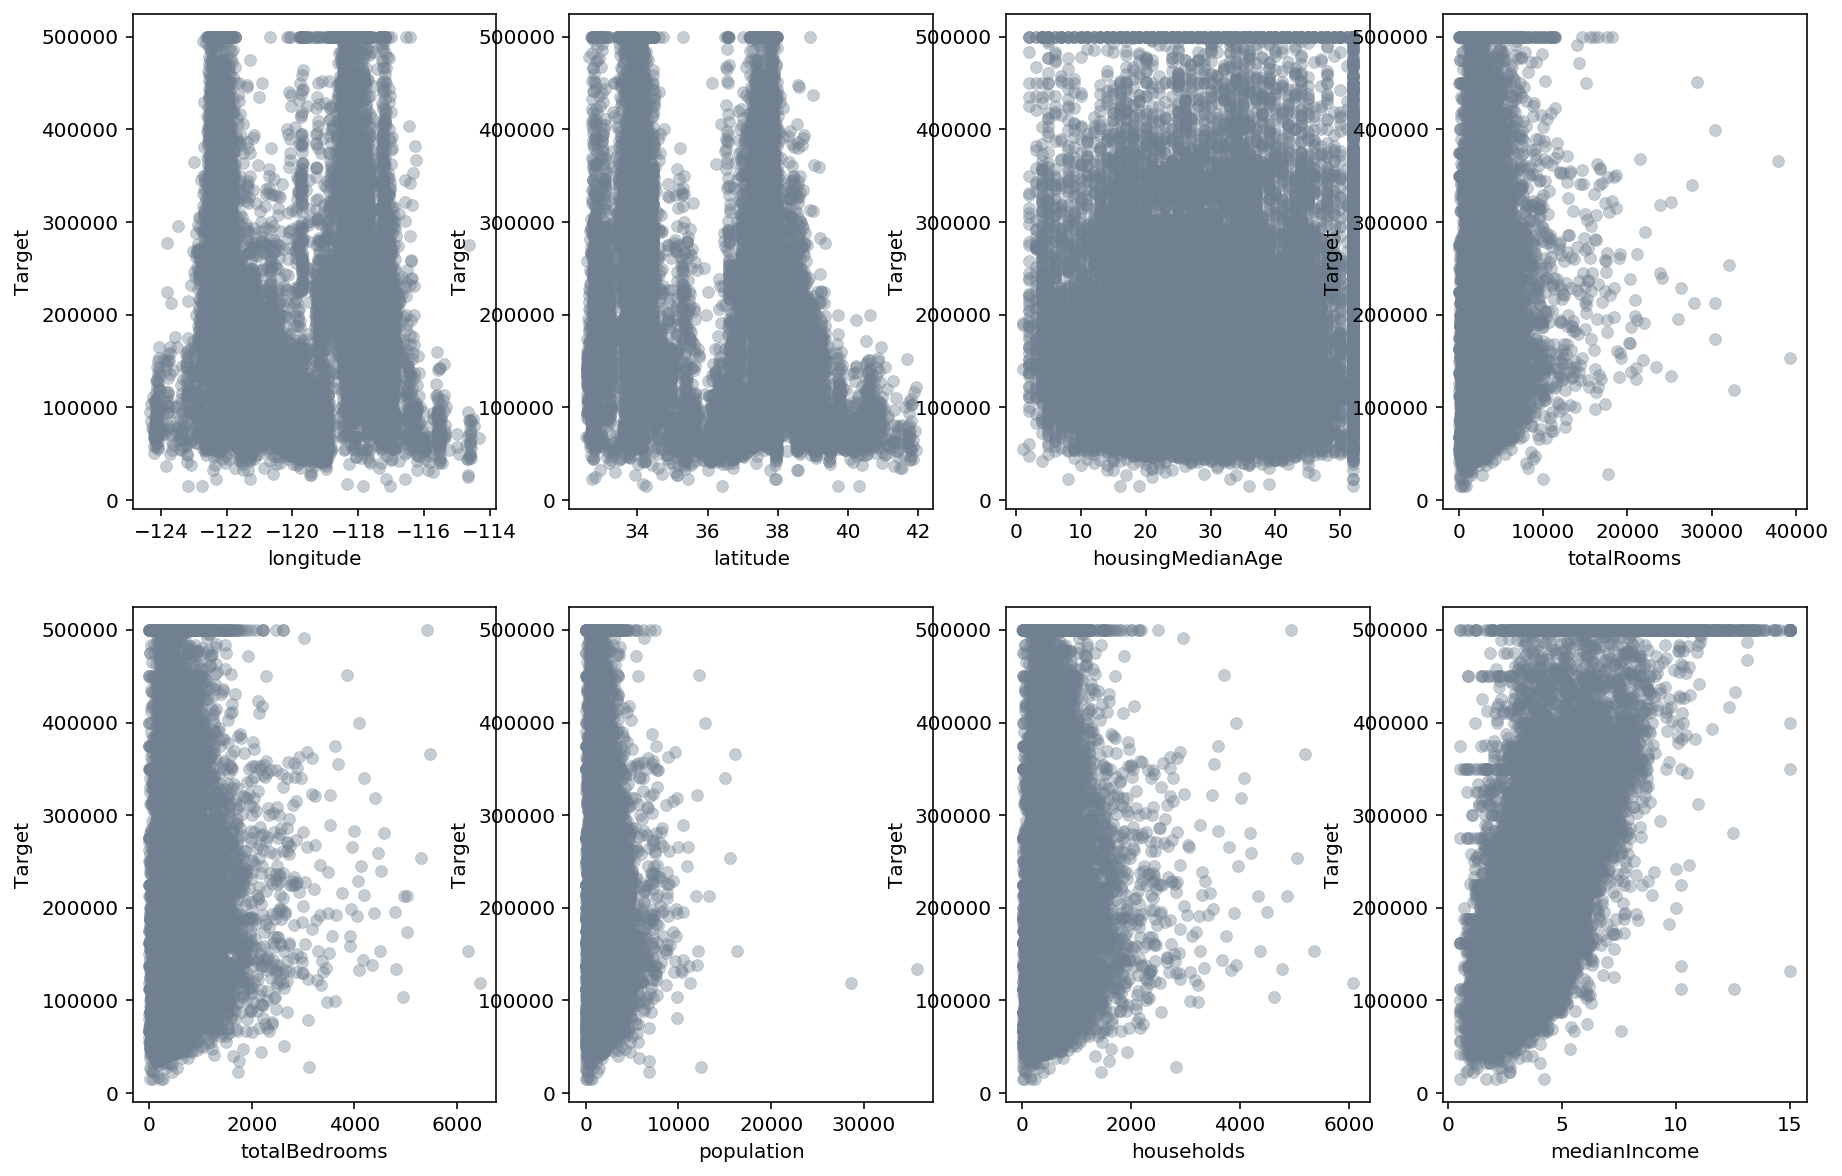

In [25]:
fig, axes = plt.subplots(2,4,figsize=(15,10))

for i in range(8):
    plt_i = i // 4
    plt_j = i % 4
    subX = X_CA_H[X_CA_H.columns[i]]
    # plt.subplot(2, 4, 1 + i)
    axes[plt_i][plt_j].scatter(subX, y_CA_H, c="slategray", alpha=0.4, linewidths=0.3)
    #plt.scatter(subX_test, y_test)
    axes[plt_i][plt_j].set_xlabel(X_CA_H.columns[i])
    axes[plt_i][plt_j].set_ylabel('Target'); 

In [34]:
model = sm.OLS(y_CA_H, X_CA_H)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:       medianHouseValue   R-squared (uncentered):                   0.900
Model:                            OLS   Adj. R-squared (uncentered):              0.900
Method:                 Least Squares   F-statistic:                          2.323e+04
Date:                Mon, 16 Mar 2020   Prob (F-statistic):                        0.00
Time:                        00:44:30   Log-Likelihood:                     -2.6093e+05
No. Observations:               20639   AIC:                                  5.219e+05
Df Residuals:                   20631   BIC:                                  5.219e+05
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------